In [1]:
import cv2
# import autograd.numpy as np
# from autograd import grad
from scipy.signal import convolve2d
from scipy.sparse.linalg import bicg
from scipy.sparse.linalg import gmres

from scipy.optimize import fmin_cg
from scipy.optimize import minimize
from importnb import Notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.fft as fft
import numpy.matlib
from skimage.transform import rotate
import sys
from tqdm import tqdm_notebook as tqdm
import sklearn
import sklearn.neighbors as neighbors

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import aslinearoperator
import numpy as np
from scipy.sparse.linalg import bicg, bicgstab
from scipy.signal import convolve2d

# from sklearn.neighbors import LSHForest

In [2]:
with Notebook(): 
        import utils
        import pinkNoise
        import reblur

## patch recurence

In [25]:
itera = 1
patchSize = 7
alpha = 4/3
beta = patchSize*patchSize
lam = 30*beta
lambda2 = 0#patchSize*patchSize
max_mag = patchSize-2

In [26]:
def upscalePatchSize():
    global patchSize, alpha, beta, lam, max_mag
    
    p = int(patchSize*alpha)
    patchSize = p if p%2==1 else p+1
    
    beta = patchSize**2
    lam = 30*beta
    max_mag = patchSize-2
    
#     m = int(max_mag*alpha)
#     m = m if m%2==0 else m+1
#     max_mag = min(p-2, m)
    
    

In [27]:
def downscale(x, alpha, show=False):
    '''
     @input x: blurred img x
     @input alpha: scaling factor 

     @return: downscaled image (x/alpha)
    '''
    downscaled_image = cv2.resize(x,None, fx=1/alpha,fy=1/alpha,interpolation=cv2.INTER_LANCZOS4)
    
    if show:
        plt.imshow(downscaled_image, cmap='gray')
        plt.figure()
        plt.imshow(x, cmap='gray')
        plt.show()
        downscaled_image.shape, x.shape
    
    return downscaled_image

image ./resources/blurcheetah.jpg loaded
(180, 49)
(321, 481)


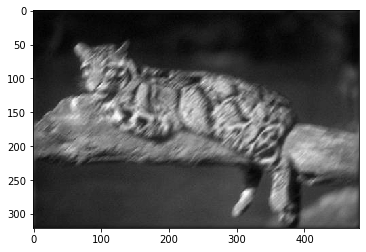

In [43]:
img = utils.loadImage('./resources/blurcheetah.jpg', 'gray')/255
kernels = reblur.generateKernels(max_mag, 1, patchSize)

x = img
print(x.shape)
plt.imshow(x, cmap='gray')


In [44]:
from annoy import AnnoyIndex

class AnnoyKNN:
    def __init__(self, patch_size, method):
        self.patch_size = patch_size
        self.feature_dims = patch_size*patch_size
        self.KNN = AnnoyIndex(self.feature_dims, method)

    
    def make_index(self, img):
        """
            make indices to be used for search in KNN
            patches are flatten and treated as 1D vectors
        """
        img = utils.im2col(img, [self.patch_size, self.patch_size])
        for i in range(img.shape[1]):
            self.KNN.add_item(i, (img.T)[i,:])
            
    def build(self, n_trees):
        """
            specify the no. of trees to be used
            more trees -> higher accuracy, higher search time
        """
        self.KNN.build(n_trees)
        
    def get_nn(self, patch):
        """
            input patch to be searched
            returns the nearest patch from indices
        """
        nn = self.KNN.get_nns_by_vector(patch.flatten(), 1)
        nn = self.KNN.get_item_vector(nn[0])
        return (np.array(nn)).reshape((self.patch_size, self.patch_size))

In [45]:
from annoy import AnnoyIndex
import random
import time

def getPrior(img, patch_size, alpha):
    """
    @input img: size (n x m)
    @input patch_size
    @input alpha
    
    @return z: size (n x m)
    """
    
    start = time.time()
    M = patch_size
    x_alpha = downscale(img, alpha)
    n,m = img.shape
    
    KNN = AnnoyKNN(M, 'euclidean')
    KNN.make_index(x_alpha)
    KNN.make_index(img)
    KNN.build(10)

    z = np.zeros(img.shape)
    counts = np.zeros(img.shape)
    
    for i in tqdm(range(M//2, n-M//2)):
        for j in range(M//2, m-M//2):
            z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += KNN.get_nn(img[i-M//2:i+M//2+1, j-M//2:j+M//2+1] + np.random.uniform(-0.01,0.01,size=(M,M)))
            counts[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += 1
            
    end = time.time()
    print('time taken:', end-start)
    
    return z/counts

In [46]:
# K_mat = bkMat(7*np.ones(img.shape), 45*np.ones(img.shape), 9)

K_mat = np.zeros((9*9, img.shape[0]*img.shape[1]))
K_matrot = K_mat


In [47]:


def call_func(x):
    global itera
    print("            Iter -> {}                  ".format(itera),end='\r')
    itera += 1

def myConvolve(img, kernel_matrix, patch_size=patchSize):
    outp = np.zeros(img.shape)
    
    pd = patch_size // 2
    img_shape = img.shape
    pimg = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    col_img = utils.im2col(pimg, [patch_size, patch_size])
    outp = np.sum(col_img * kernel_matrix, axis = 0)

    return outp.reshape(img_shape)

def myConvolveLaplacian(img, patch_size = patchSize):
    pd = 1
    pimg = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    col_img = utils.im2col(pimg, [3,3])
    laplac = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]]).ravel()
    oimg = np.sum(col_img*laplac[:,None], axis=0)

    return oimg

def myConvolveGamma(img, gamma=0.5):
    pd = 1
    pimg = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    col_img = utils.im2col(pimg, [3,3])
    oimg = col_img - col_img[4,:]
    oimg = np.power(oimg, gamma-1)
    oimg = np.sum(np.abs(col_img), axis=0)

    return oimg

def make_mv(ss, K_mat, K_matrot, patchSize, lam, beta):
    def mv(x):
        img = x.reshape(ss)
        outp = myConvolve(img, K_mat, patch_size=patchSize)
        foutp = myConvolve(outp, K_matrot, patch_size=patchSize)
        goimg = myConvolveGamma(img)

        return lam*foutp.ravel() + beta*x + 0.005*goimg
    return mv




In [48]:
from scipy.optimize import fmin_bfgs

def EPLLhalfQuadraticSplitDeblur(oldI, noiseI, lam, patchSize, beta, T, alpha):
    global itera
    cleanI = noiseI
    ss = noiseI.shape
    for tt in range(T):
        print("Iteration -> {}       ".format(tt))
        itera = 0
        idxs = reblur.getImageBlurEstimates(cleanI, oldI, kernels, patchSize)
        K_mat = kernels[:, idxs]
        K_matrot =  K_mat
        prior = getPrior(cleanI, patchSize, alpha)
        tt1 = oldI
        tt1 = myConvolve(tt1, K_matrot)
        
        func = make_mv(ss, K_mat, K_matrot, patchSize, lam, beta)
        A = LinearOperator((ss[0]*ss[1], ss[0]*ss[1]), matvec=func, rmatvec=func)
        
        cleanI = gmres(A, lam*tt1.ravel() + beta*prior.ravel(), tol=1e-5, callback=call_func, x0=prior.ravel(), maxiter=100)
        cleanI = np.reshape(cleanI[0], noiseI.shape)
        
#         un = np.unique(cleanI.ravel())
#         mi = 0#un[1*un.shape[0]//100]
#         ma = 1#un[-1*un.shape[0]//100]
#         cleanI = np.where(cleanI<mi, mi, cleanI)
#         cleanI = np.where(cleanI>ma, ma, cleanI)
        
#         cleanI = (cleanI-cleanI.min())/(cleanI.max()-cleanI.min())
        
#         arr = plt.subplots(1,2, figsize = (30,30))[1]
#         arr[0].imshow(prior, cmap='gray')
#         arr[1].imshow(cleanI, cmap='gray')
#         plt.show()

    return cleanI

In [55]:
cleanI2 = None

def final(img, down_fac, ups_fac):
    new_img = downscale(img, down_fac)
    original_image = downscale(img, down_fac)
    
    while new_img.shape[0]*new_img.shape[1] <= img.shape[0]*img.shape[1]:
        cleanI = EPLLhalfQuadraticSplitDeblur(original_image, new_img, lam, patchSize, beta, 3, alpha)
        arr = plt.subplots(1,2, figsize = (30,30))[1]
        
        mi = un[1*un.shape[0]//100]
        ma = un[-1*un.shape[0]//100]
        cleanI2 = np.where(cleanI<mi, mi, cleanI)
        cleanI2 = np.where(cleanI2>ma, ma, cleanI2)
        
        new_img = downscale(cleanI, 1/ups_fac)
        original_image = downscale(original_image, 1/ups_fac)
        arr[0].imshow(new_img, cmap='gray')
        arr[1].imshow(cleanI2, cmap='gray')
        plt.show()

Iteration -> 0       
38.71247964283705


/envs/bluring/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



time taken: 1.6897227764129639


/envs/bluring/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in power
/envs/bluring/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power


Iteration -> 1       3                  
45.28723554712016



time taken: 1.718369722366333
Iteration -> 2       4                  
35.04612699233839



time taken: 1.663360357284546


NameError: name 'un' is not defined

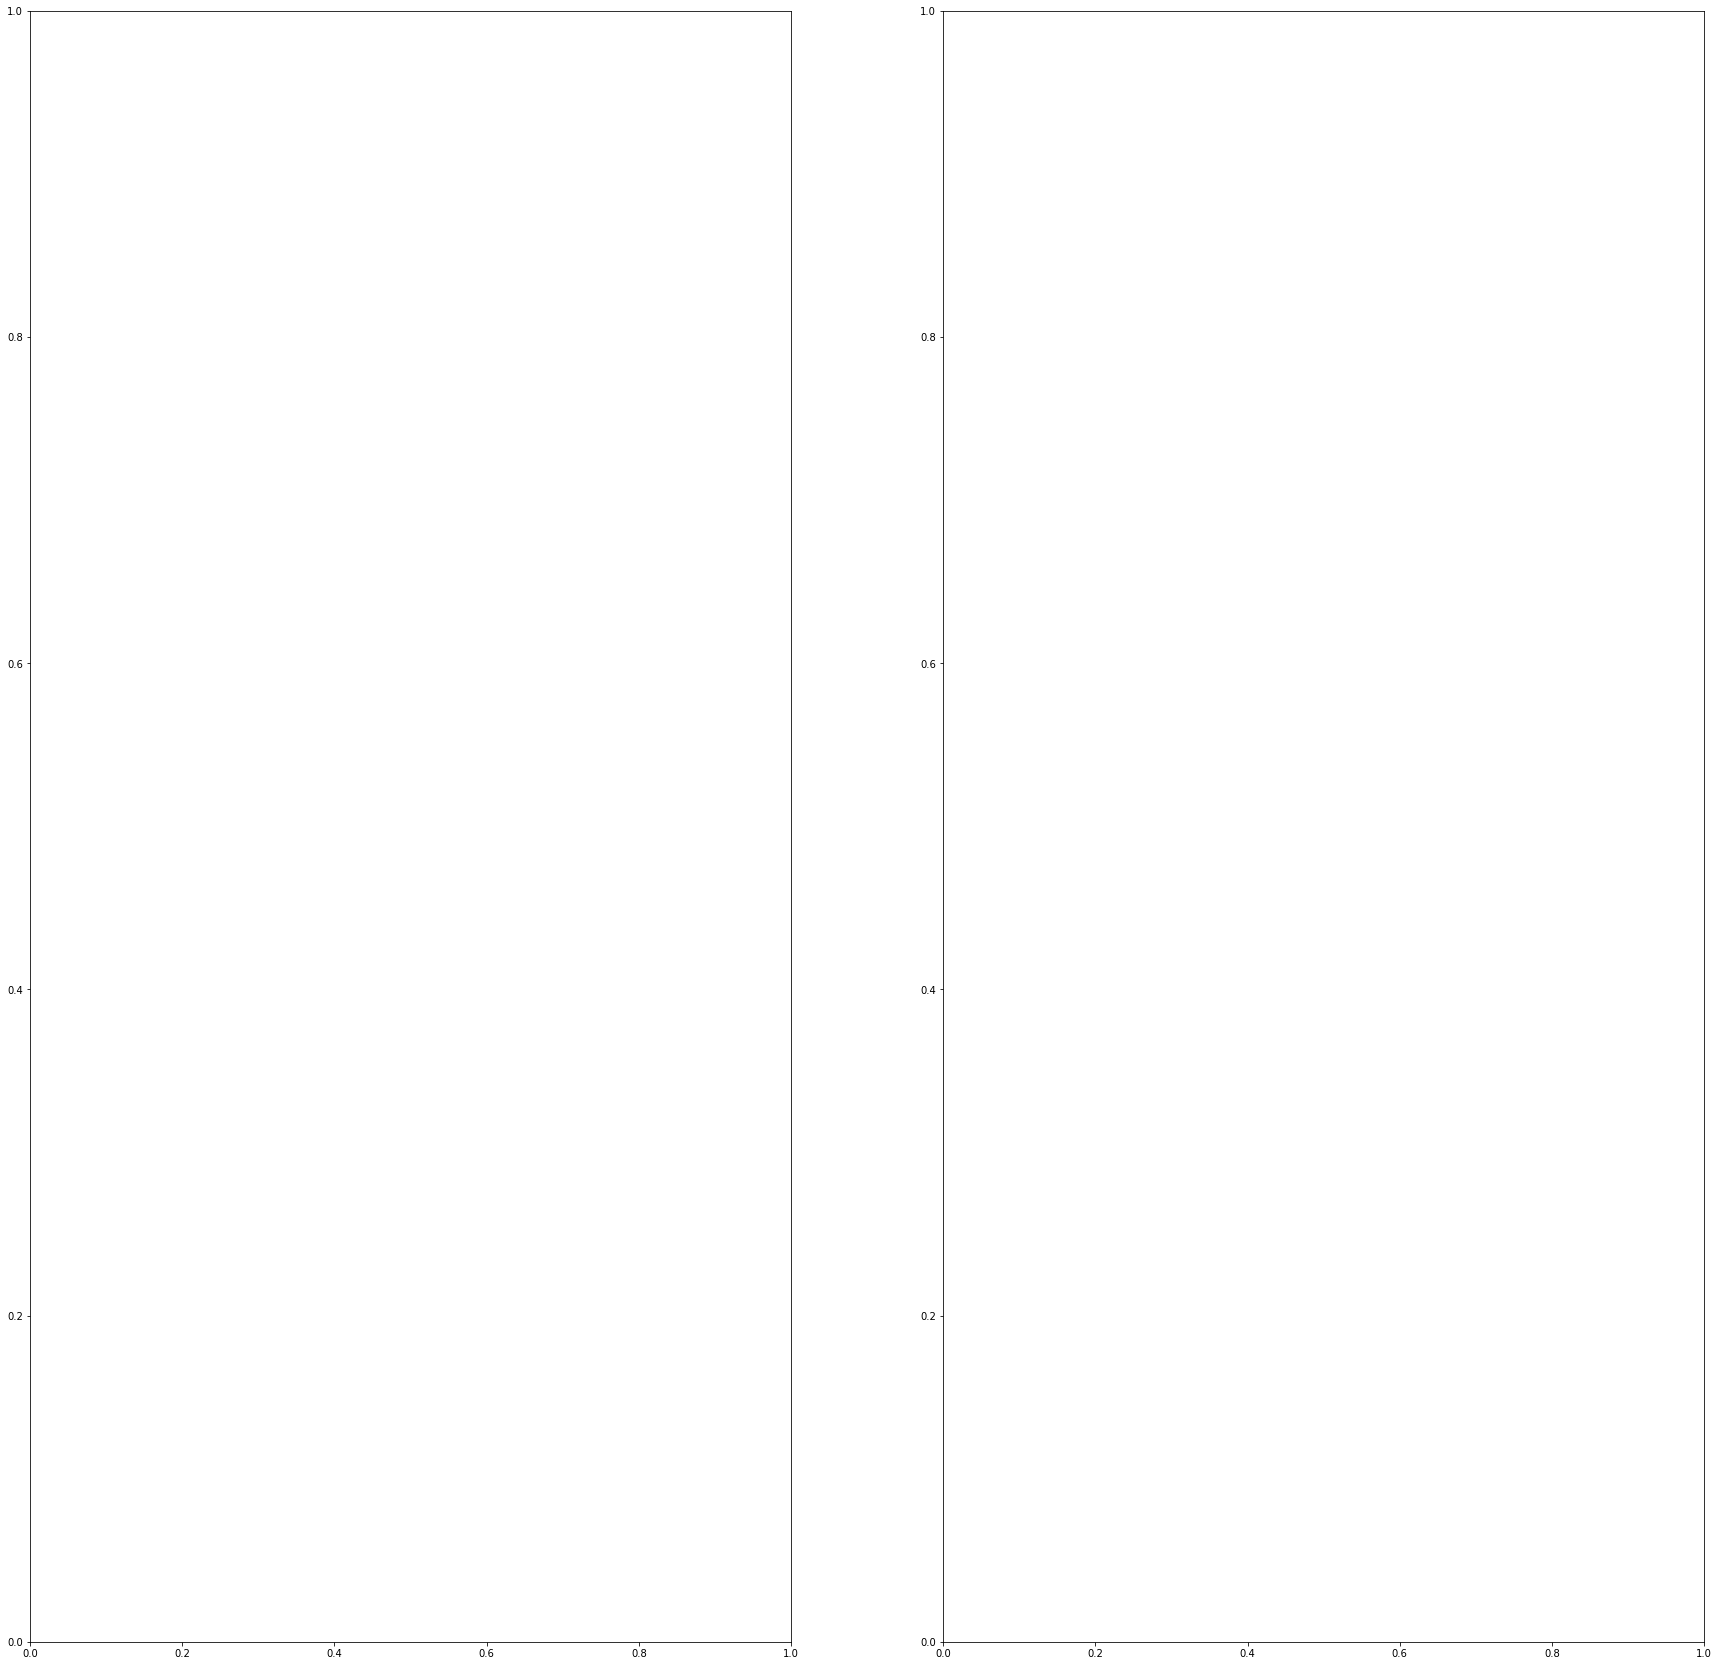

In [56]:
final(x, 2, 4/3)